## Desafío entregable #12: Ingeniería de atributos y selección de variables

In [421]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point

En este desafío se trabajará con el dataset "California Housing", el cual resumen información inmobiliaria de dicho estado de los EE.UU. Dicha información esta agrupada en "block groups" (BG), el cual es la unidad geográfica más pequeña que el U.S. Census Bureau registra informacion. Otra agrupación presente en el dataset es "household" (HH), que es el número de personas residentes en una casa. Un block group típicamente vive entre 600 y 3000 personas. Las variables presentes en el dataset son:

- longitude: longitud del BG.
- latitude: latitud del BG.
- housing_median_age: mediana de la edad del BG.
- total_rooms: promedio de ambientes por HH. 
- total_bedrooms: promedio de habitaciones por HH.
- population: población del BG.
- households: número de HH por BG. 
- median_income: mediana del ingreso del BG.
- median_house_value: mediana del valor del HH.  
- ocean_proximity: cercanía al océano, variable categórica.
- gender: género mayoritario del BG.

El objetivo es predecir la mediana del valor de los inmuebles, expresados en cientos de miles de dólares (US$ 100.000). Esta entrega hace foco en la reducción de la dimensionalidad, se emplearan diferentes metodologías y se las comparará.

El procedimiento de limpieza, curado y estandarizacion/normalización de los datos es el mismo de la entrega anterior y no se los describirá en detalle.

In [422]:
df = pd.read_csv('Housing_Price.csv')

## Repaso del dataset

In [423]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20382 non-null  float64
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      15758 non-null  float64
 5   population          20596 non-null  float64
 6   households          19335 non-null  object 
 7   median_income       17873 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
 10  gender              16620 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 1.7+ MB


In [424]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.0100,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.7100,41.9500
housing_median_age,20382.0,28.676283,12.589284,1.0000,18.0000,29.0000,37.0000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.0000,39320.0000
total_bedrooms,15758.0,539.920104,419.834171,1.0000,296.0000,435.0000,652.0000,6210.0000
population,20596.0,1424.928724,1132.237768,3.0000,787.0000,1166.0000,1725.0000,35682.0000
median_income,17873.0,3.939403,1.943517,0.4999,2.5986,3.5871,4.8304,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.0000,500001.0000


In [425]:
df.describe(include = "object").T

,count,unique,top,freq
households,19335,1703,no,3080
ocean_proximity,20640,5,<1H OCEAN,9136
gender,16620,2,female,8673


## Limpieza de datos

In [426]:
df['households'].replace("no", np.nan , inplace=True)
df['households'] = df['households'].astype('float64')

### Tratamiento de datos tipo NaN

In [427]:
df.drop(['gender'], axis = 1, inplace = True)

In [428]:
ord = preprocessing.OrdinalEncoder()
df['ocean_proximity'] = ord.fit_transform(df[['ocean_proximity']])

In [429]:
imputer = KNNImputer(n_neighbors = 5, weights = "uniform")
df2 = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

## Curación de datos

In [430]:
coastal_shapefile_path = "ne_110m_coastline/ne_110m_coastline.shp"
coastal_data = gpd.read_file(coastal_shapefile_path)

In [431]:
df2['distance_coast'] = None

for index, row in df2.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    
    point = Point(longitude, latitude)
    distances = coastal_data.distance(point) # Calculamos la distancia a todos los puntos de la costa
    distances_min = distances.min() # Encontramos el mínimo valor de distancia

    df2.at[index, 'distance_coast'] = distances_min * 111.0445 
    
df2['distance_coast'] = df2['distance_coast'].astype('float64')

C:\Users\mauri\AppData\Local\Temp\ipykernel_1616\1402484739.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = coastal_data.distance(point) # Calculamos la distancia a todos los puntos de la costa


In [432]:
los_angeles = [34.1141, -118.4068] # Longitud y latitud
san_diego = [32.8313, -117.1222]
san_jose = [37.3012, -121.848]
san_francisco = [37.7558, -122.4449]
fresno = [36.783, -119.7939]

cities = [los_angeles, san_diego, san_jose, san_francisco, fresno]
names = ['los_angeles', 'san_diego', 'san_jose', 'san_francisco', 'fresno']

In [433]:
for i in range(len(cities)):
    
    df2[f'distance_{names[i]}'] = None

    for index, row in df.iterrows():
        latitude = row['latitude']
        longitude = row['longitude']
        
        point1 = Point(cities[i][1], cities[i][0])
        point2 = Point(longitude, latitude)
        
        distance = point1.distance(point2)
        
        df2.at[index, f'distance_{names[i]}'] = distance * 111.0445 
        
    df2[f'distance_{names[i]}'] = df2[f'distance_{names[i]}'].astype('float64')

In [434]:
df2.drop(['ocean_proximity', 'latitude', 'longitude'], axis = 1, inplace = True)

## Reducción de dimensionalidad

Se disponen de varias formas de seleccionar variables o reducirlas, en esta entrega se utilizaron los métodos de evaluación de la colinealidad, la selección por importancia de variables (usando bosques de decisión), la selección sequencial y el análisis por componentes principales. 

In [435]:
df3 = df2.copy()

X = df3.drop(['median_house_value'], axis = 1) 
y = df3['median_house_value']

Como se mencionó, la variable objetivo la media del valor de las propiedades, es el valor que se busca predecir a partir del análisis de las otras variables del dataset.

In [436]:
df_orig = X

Se guarda el dataset original (en realidad, curado) para comparar.

### Colinealidad

El análisis por colinealidad busca apartar aquellas variables que presenten coeficientes de correlación lineal (R) que superen un cierto umbral, con otras variables.

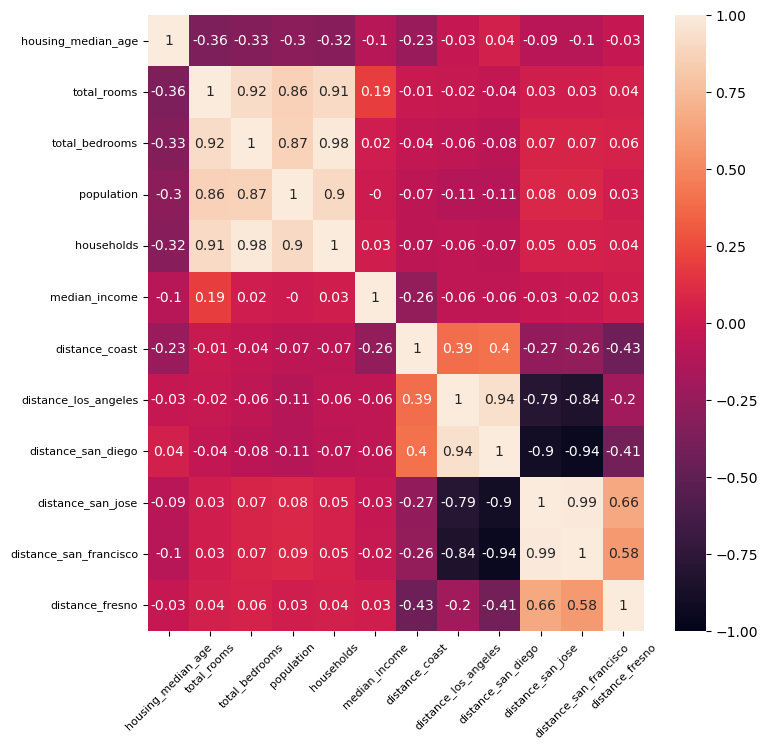

In [437]:
plt.figure(figsize=(8,8))
sns.heatmap(X.corr().round(2), vmin=-1, vmax=1, cbar = True, annot=True)
plt.xticks(fontsize = 8, rotation=45) 
plt.yticks(fontsize = 8) 
plt.show()

El mapa de calor vislumbra rápidamente que hay varias variables que presentan altos valores de R. Buscaremos eliminar aquellas variables que spueren el umbral de 0.9.

In [438]:
umbral = 0.9
corr = X.corr().abs()

sup = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))
sup.head()

C:\Users\mauri\AppData\Local\Temp\ipykernel_1616\2578130705.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sup = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,distance_coast,distance_los_angeles,distance_san_diego,distance_san_jose,distance_san_francisco,distance_fresno
housing_median_age,NaN,0.361736,0.331127,0.296877,0.317065,0.098956,0.229962,0.034049,0.042988,0.088069,0.104035,0.033086
total_rooms,NaN,NaN,0.923850,0.857057,0.913083,0.192682,0.014196,0.017200,0.040393,0.033094,0.034208,0.042661
total_bedrooms,NaN,NaN,NaN,0.871919,0.976239,0.020107,0.040096,0.061770,0.075367,0.067475,0.068179,0.057026
population,NaN,NaN,NaN,NaN,0.898107,0.002341,0.066271,0.107755,0.110316,0.079955,0.089524,0.034572
households,NaN,NaN,NaN,NaN,NaN,0.034082,0.069167,0.063397,0.070893,0.051488,0.053511,0.044370


In [439]:
alta_corr = [column for column in sup.columns if any(sup[column] > umbral)]
alta_corr

['total_bedrooms',
 'households',
 'distance_san_diego',
 'distance_san_francisco']

Estas son las variables que presentan valores de R superiores a 0.9 y serán eliminadas del dataset, el nuevo dataset se denomina "df_colinear"

In [440]:
df_colinear = X.drop(columns = alta_corr)
y_col = y

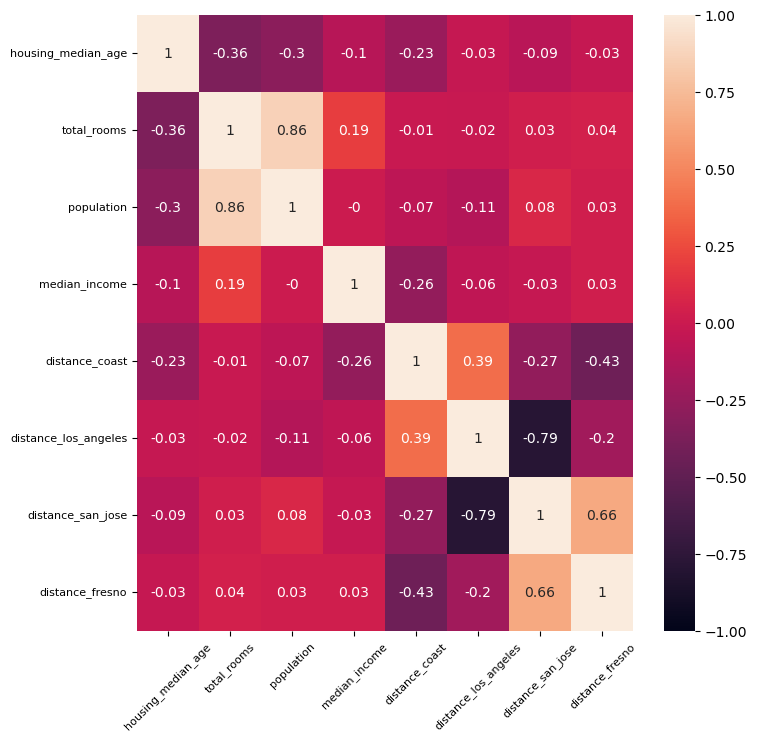

In [441]:
plt.figure(figsize=(8,8))
sns.heatmap(df_colinear.corr().round(2), vmin=-1, vmax=1, cbar = True, annot=True)
plt.xticks(fontsize = 8, rotation=45) 
plt.yticks(fontsize = 8) 
plt.show()

El mapa de calor inmediatamente anterior, obtenido a partir del dataset sin correlaciones altas muestra, justamente, correlaciones por debajo del umbral elegido. 

### Importancia de las variables

Este métedo hace uso de un bosque de decisión para evaluar la importancia de las variables en una tarea artificial de regresión, empleando alguna medida de la calidad de la separación en ramas. Debido a que es precisamente el empleo de un algoritmo de aprendizaje automático, primero se estandarizarán las variables.

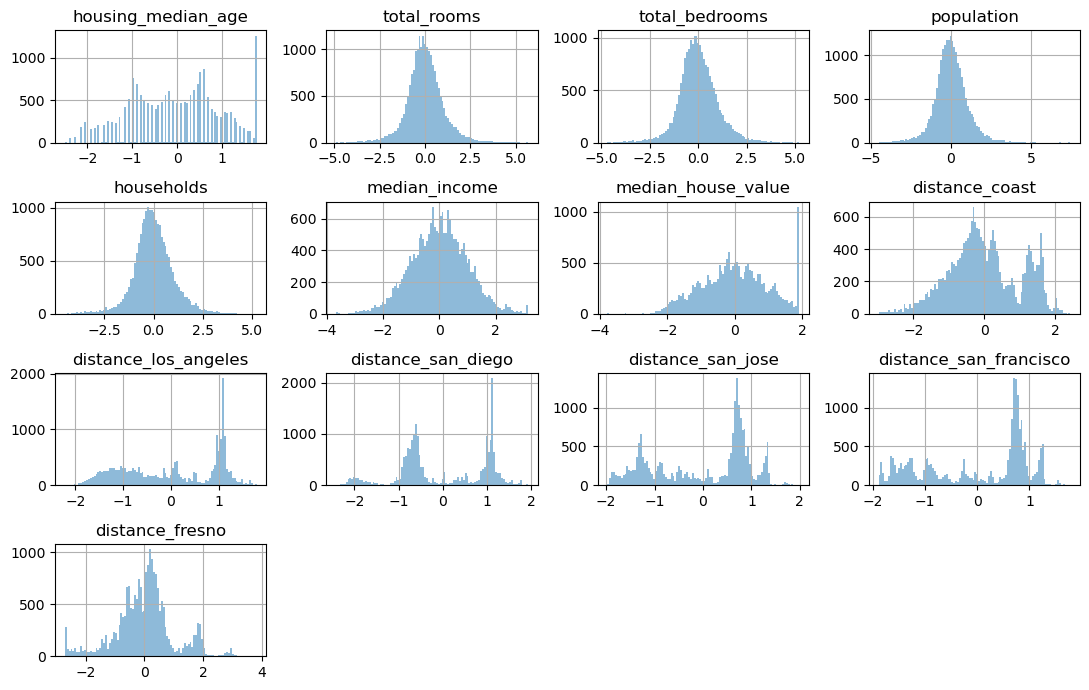

In [442]:
pt = PowerTransformer()

df4 = pd.DataFrame(pt.fit_transform(df3), columns = df3.columns)

df4.hist(bins=100, alpha=0.5, figsize=(11, 7))
plt.tight_layout()
plt.show()

In [443]:
from sklearn.ensemble import RandomForestRegressor

In [444]:
X = df4.drop(['median_house_value'], axis = 1) 
y = df4['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [445]:
regr = RandomForestRegressor(max_depth = 3, random_state = 0)

regr.fit(X_train, y_train)
impor_variable = regr.feature_importances_

Aplicamos un Random Forest y obtenemos la importancia de las variables a partir del método "feature_importances_".

In [446]:
importancias = pd.DataFrame({'feature': list(X.columns), 'importance': impor_variable}).sort_values('importance', ascending = False)
importancias

,feature,importance
6,distance_coast,0.521505
5,median_income,0.474019
11,distance_fresno,0.004362
10,distance_san_francisco,0.000114
0,housing_median_age,0.000000
1,total_rooms,0.000000
2,total_bedrooms,0.000000
3,population,0.000000
4,households,0.000000
7,distance_los_angeles,0.000000


Se observa que unas pocas variables poseen importancia significativa, mientras muchas otras no contribuyen al poder predictivo, esto en realidad es capcioso. Si aumentamos la profundidad del bosque, el algoritmo en algún momento utilizará otras variables para decidir, pudiendo dar importancia distinta de cero a todas las variables del dataset. Es de sobra conocido la facilidad de los árboles/bosques de decisión de incurrir en overfitting, por lo que se requiere de un análisis del under/overfitting. No realizaremos dicho análisis, confiando en un "max_depth" conservador.

In [447]:
impor_nulas = list(importancias[importancias['importance'] == 0.0]['feature'])
impor_nulas

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'distance_los_angeles',
 'distance_san_diego',
 'distance_san_jose']

Estas son las variables que descartaremos, dado que no parecen contribuir a la predición de la mediana del valor de los inmuebles.

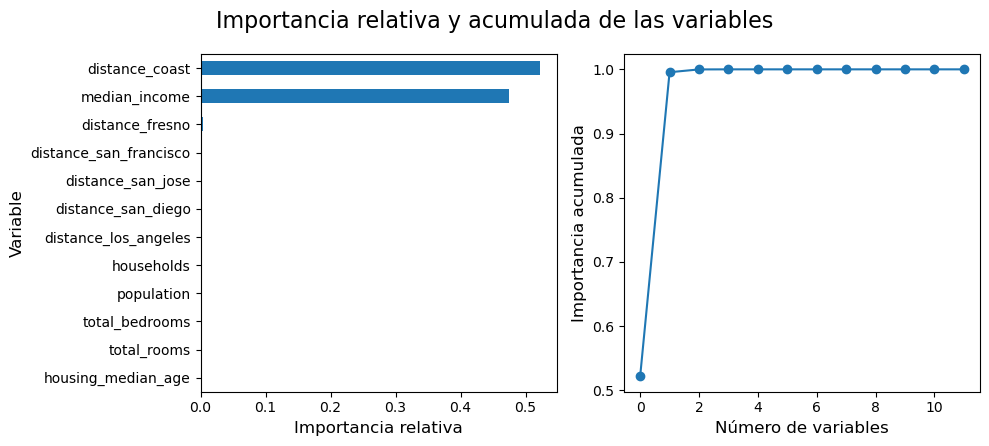

In [448]:
importancias['cumulative_importance'] = np.cumsum(importancias['importance'])

fig, axes = plt.subplots(1,2, figsize = (10, 4.5))

importancias.sort_values('importance', ascending=True).plot.barh(y='importance', x='feature', legend=False, ax = axes[0])
axes[1].plot(list(range(len(importancias))), importancias['cumulative_importance'], '-o')

axes[0].set_xlabel('Importancia relativa', fontsize = 12); axes[0].set_ylabel('Variable', fontsize = 12)
axes[1].set_xlabel('Número de variables', fontsize = 12); axes[1].set_ylabel('Importancia acumulada', fontsize = 12)
plt.suptitle('Importancia relativa y acumulada de las variables', fontsize = 16)

plt.tight_layout()
plt.show()

Por medios de estos gráficos se observa que dos de las variables, "distance_coast" y "median_income", presentan con diferencia, las mayores importancias. Como se mencionó, las variables con importancias nulas son eliminadas a continuación.

In [449]:
df_import = X.drop(columns = impor_nulas)
df_import.head()

,median_income,distance_coast,distance_san_francisco,distance_fresno
0,1.926231,-0.098137,-1.602920,-0.314668
1,1.920074,-0.087038,-1.603219,-0.331393
2,1.628791,-0.152815,-1.623067,-0.317584
3,1.073383,-0.183544,-1.631276,-0.308713
4,0.211877,-0.183544,-1.631276,-0.308713


### Selección sequencial de variables

Se evaluó, de forma sequencial, cuales son las variables que más peso poseen en el dataset, para ello se utilizó el algoritmo Sequential Feature Selector junto al regresor Huber. 

In [450]:
from sklearn.linear_model import HuberRegressor

In [451]:
huber = HuberRegressor()

forw = {}

for i in [3, 5, 7, 9, 11]:
    forw[f'sfs_{i}'] = SequentialFeatureSelector(huber, n_features_to_select = i)
    forw[f'sfs_{i}'].fit(X_train, y_train)
    print(f'Las {i} variables seleccionadas son: \n', list(X_train.columns[forw[f'sfs_{i}'].get_support()]))
    forw[f'sfs_{i}_var'] = X_train.columns[forw[f'sfs_{i}'].get_support()]

Las 3 variables seleccionadas son: 
 ['median_income', 'distance_coast', 'distance_san_jose']
Las 5 variables seleccionadas son: 
 ['median_income', 'distance_coast', 'distance_los_angeles', 'distance_san_jose', 'distance_fresno']
Las 7 variables seleccionadas son: 
 ['total_bedrooms', 'population', 'median_income', 'distance_coast', 'distance_los_angeles', 'distance_san_jose', 'distance_fresno']
Las 9 variables seleccionadas son: 
 ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'distance_coast', 'distance_los_angeles', 'distance_san_jose', 'distance_fresno']
Las 11 variables seleccionadas son: 
 ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'distance_coast', 'distance_los_angeles', 'distance_san_jose', 'distance_san_francisco', 'distance_fresno']


Se utilizó el algoritmo HuberRegressor para realizar el proceso de Feature Selection. Se seleccionó 3, 5, 7, 9 y 11 variables en cada caso, la cual se denominan Sprint 3, Sprint 5, ..., y Sprint 11. Se aplicó sólo la dirección "forward". A continuación, se utilizaron modelos de HuberRegressor usando las variables seleccionadas en cada caso y se evaluarán las métricas.

In [452]:
MAE, MSE, r2 = [], [], []

for i in [3, 5, 7, 9, 11]:
    X_i = X[list(X.columns[forw[f'sfs_{i}'].get_support()])]
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, random_state = 42)
    
    huber.fit(X_train, y_train)
    y_pred = huber.predict(X_test)
    
    MAE.append(mean_absolute_error(y_test, y_pred))
    MSE.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))

In [453]:
Model = [f'Sprint {2*i+1}' for i in range(1,6)]
comparacion_forw = pd.DataFrame({'Modelo': Model, 'MAE': MAE, 'MSE': MSE, 'R2': r2})
comparacion_forw.round(2)

,Modelo,MAE,MSE,R2
0,Sprint 3,0.44,0.34,0.67
1,Sprint 5,0.40,0.29,0.71
2,Sprint 7,0.38,0.26,0.74
3,Sprint 9,0.38,0.26,0.75
4,Sprint 11,0.38,0.26,0.75


Se elige el Sprint 5 puesto que posee las mejores métricas manteniendo el modelo relativamente sencillo.

In [454]:
X_5 = list(X.columns[forw['sfs_5'].get_support()])

df_forward = df4[X_5]
df_forward.head()

,median_income,distance_coast,distance_los_angeles,distance_san_jose,distance_fresno
0,1.926231,-0.098137,1.094817,-1.312862,-0.314668
1,1.920074,-0.087038,1.090517,-1.328372,-0.331393
2,1.628791,-0.152815,1.092002,-1.326180,-0.317584
3,1.073383,-0.183544,1.093459,-1.322075,-0.308713
4,0.211877,-0.183544,1.093459,-1.322075,-0.308713


### Análisis de componentes principales (PCA)

PCA es una técnica de reducción de dimensionalidad, la cual consiste en la determinación de un espacio de menor dimensión, que retiene la mayor parte de la información. Busca encontrar nuevas variables, llamadas componentes principales (PC), ortogonales entre sí y que son combinaciones lineales de las variables originales. A lo largo de estas componentes, la varianza es máxima.  

In [455]:
from sklearn.decomposition import PCA

La varianza explicada es del 66.7 %.


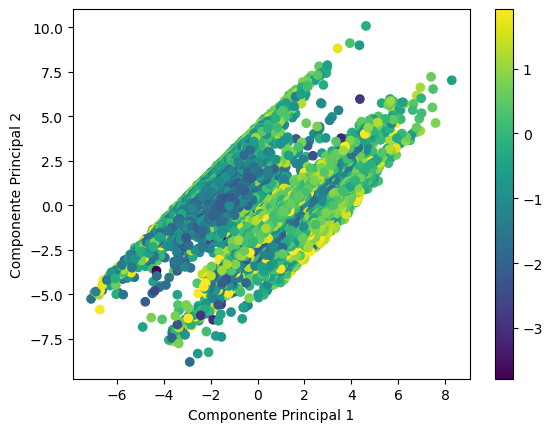

In [456]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
total_varianza = np.sum(pca.explained_variance_ratio_).round(4)

print(f'La varianza explicada es del {100*total_varianza} %.')
    
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap = 'viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar()
plt.show()

A los fines de explorar el funcionamiento de PCA, se aplicó una reducción de la dimesionalidad a sólo dos componentes. Estos componentes sólo dan cuenta del 66.7 % de la varianza de los datos. Por lo que se requieren de mayor número de PC. Se hace un loop for variando el número de PC y se determina en cada caso la varianza explicada.

In [457]:
varianza = []

for i in range(1,10):
    pca = PCA(n_components = i)
    X_pca = pca.fit_transform(X)
    varianza.append(np.sum(pca.explained_variance_ratio_))

varianza

[0.3590071017105312,
 0.6670303910018132,
 0.7725397152096077,
 0.8593811067915449,
 0.9288449942609383,
 0.9662198538957245,
 0.9791414725021912,
 0.9895920348329008,
 0.9946099063652603]

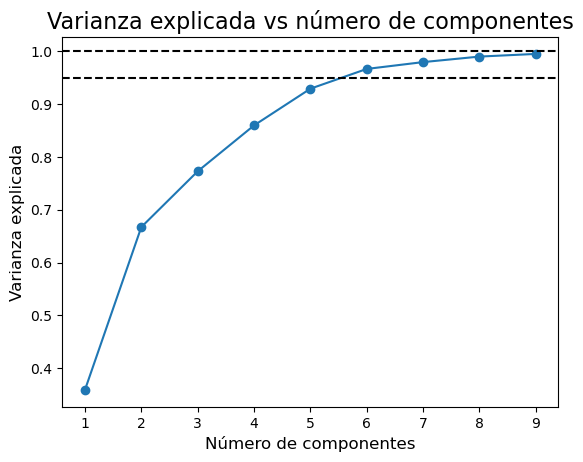

In [458]:
plt.plot(list(range(1,10)), varianza, '-o')
plt.xlabel('Número de componentes', fontsize = 12); plt.ylabel('Varianza explicada', fontsize = 12)
plt.axhline(1, color = 'black', linestyle = '--')
plt.axhline(0.95, color = 'black', linestyle = '--')
plt.title('Varianza explicada vs número de componentes', fontsize = 16)

plt.show()

Se observa gráficamente que la varianza aumenta rápidamente con el número de PC (en este dataset, en otros la situación puede ser distinta) para luego amesetarse tendiendo a 1. Tomaremos el número de PC suficiente para dar cuenta el 95 % de la varianza, es decir, seis componentes, con el cual definimos el dataset "df_pca".

In [459]:
i = 6
pca = PCA(n_components = i)
X_pca = pca.fit_transform(X)
columnas = ["PC" + str(i+1) for i in range(X_pca.shape[1])]

df_pca = pd.DataFrame(data = X_pca, columns = columnas)

## Comparación de métodos de selección de variables

En esta sección se compararán se evaluará como respone el algoritmo de regresion XGBoostRegressor en los dataframes que fueron obtenidos por los diferentes métodos de selección de variables y reducción de la dimensionalidad. Se eligió este algoritmo puesto que fue el que mejor se desempeñó en la entrega anterior. No sólo compararemos las métricas de bonda de ajuste sino que también tendremos en cuenta el tiempo de cómputo requerido para cada dataset.

In [460]:
from xgboost import XGBRegressor
import time

In [461]:
xgb = XGBRegressor()

MAE, MSE, r2, tiempo = [], [], [], []

for df in [df_orig, df_colinear, df_import, df_forward, df_pca]:
    start_time = time.time()
    X = df 
    y = df4['median_house_value']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    MAE.append(mean_absolute_error(y_test, y_pred))
    MSE.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))
    tiempo.append(execution_time)

In [463]:
comparacion = pd.DataFrame({'Modelo': ['Original', 'Colinear', 'Importancia', 'Sequencial', 'PCA'], 
                            'MAE': MAE, 
                            'MSE': MSE, 
                            'R2': r2,
                            'Tiempo (s)': tiempo})

comparacion.round(4)

,Modelo,MAE,MSE,R2,Tiempo (s)
0,Original,0.2633,0.1434,0.8577,1.5520
1,Colinear,0.2678,0.1484,0.8527,1.0643
2,Importancia,0.2832,0.1642,0.8370,0.9784
3,Sequencial,0.2780,0.1601,0.8411,1.0064
4,PCA,0.3509,0.2299,0.7718,1.2932


Empleando el dataset original, sin eliminar variables se obtienen las mejores métricas, el algoritmo logró predecir la mediana del valor de las propiedades con mayor exactitud. Los datasets Colinear, Importancia y Sequencial obtuvieron menores pero no muy diferentes. Sin embargo, el tiempo de cómputo es un 50 % menor al que usando el dataset Original, esto no es significativo en esta práctica pero puede ser determinante para dataset de millones de registros y cientos de variables, en donde un 50 % de ahorro reduce horas de cálculo. Por último PCA obtuvo métricas sensiblemente menores, posiblemente reducir a seis PC es muy agresivo y requiere de mayor número de componentes.